<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

17:01:44 Starting...
17:01:44 Installing yfinance into Google notebook...
17:01:48 Installing arch into Google notebook...
17:01:56 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

In [56]:
nprint("Getting members of %s index." % (indexname:='S&P 500'))

if indexname=='S&P 500':
    display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
    first_date=index['Date added'].max()

elif indexname=='NASDAQ-100':
    display(index:=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4].set_index("Ticker"))
    first_date=datetime.now().strftime("%Y-01-02") # NASDAQ rebalances (normally) on the first day of the year. Jan'1st. is *always* a holiday
else:
    raise ValueError("Don't know how to load members of %s Index!" % indexname)

nprint("First date is %s." % first_date)

17:49:10 Getting members of S&P 500 index.


,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969


17:49:11 First date is 2024-07-08.


In [62]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-"),index.index)),first_date)

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

18:02:58 Getting daily data for all index stocks, starting on 2024-07-08.


[*********************100%***********************]  503 of 503 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-62-395602f26453>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-62-395602f26453>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
CCL,VRTX,10.115514,42.0
LNT,EQR,18.136668,42.0
PPL,SBUX,-1.070887,42.0
CEG,MCK,-20.368758,42.0
BX,PRU,54.705919,42.0
...,...,...,...
ABT,FANG,-5.029281,42.0
LYB,AEP,9.964048,42.0
TFC,NXPI,42.195301,42.0


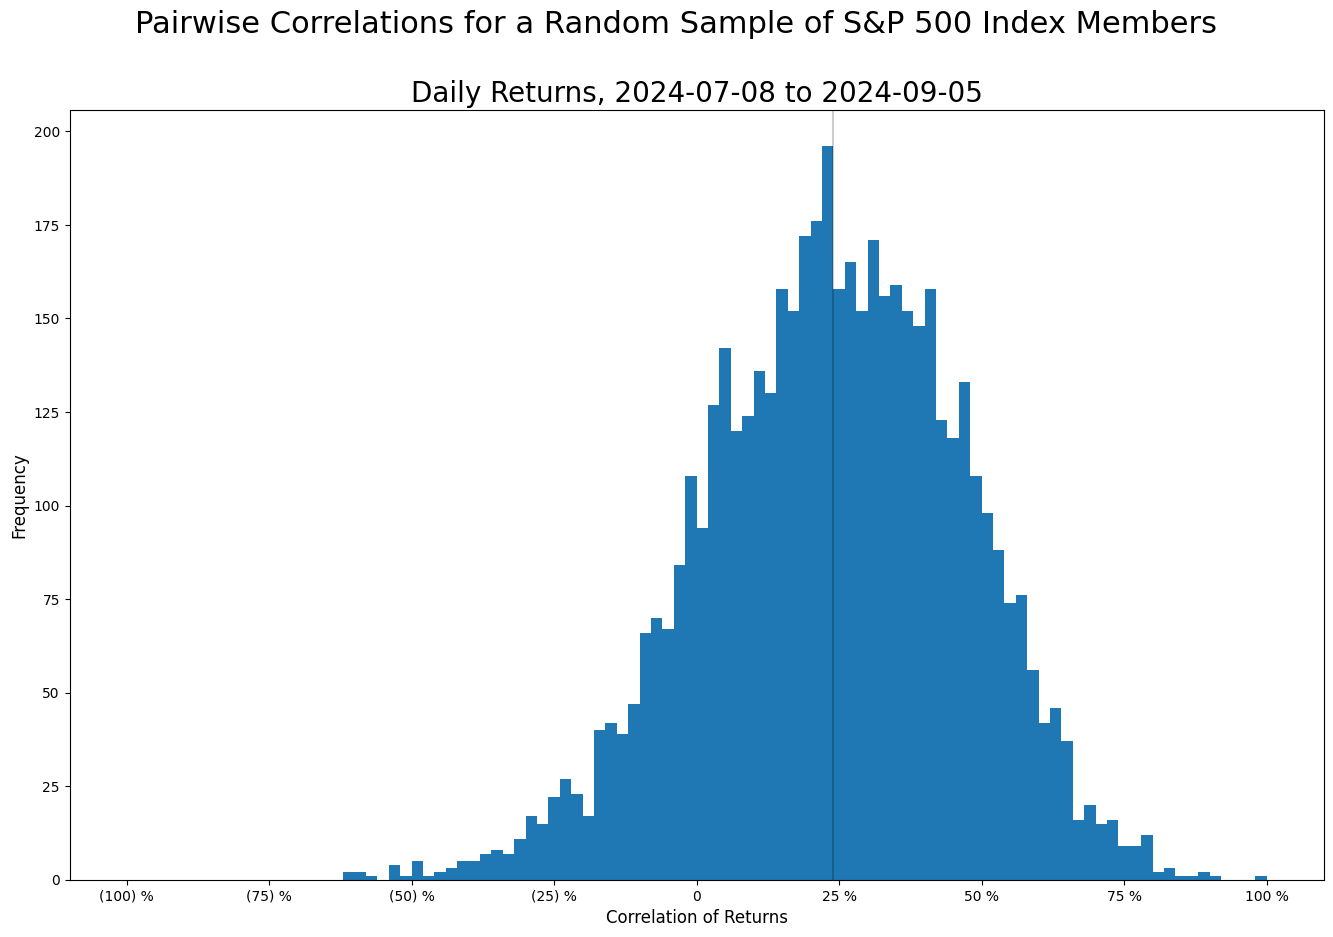

In [63]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [59]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials. This may take about {:.1f} minutes...".format(n,n/2.38/60)) # approx empirical timings

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Assets"]=returns.shape[1] # number of assets we ended up with
    results.loc[i,"Independent"]=returns.var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    results.loc[i,"Portfolio"]=returns['Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

17:53:09 Getting daily data for all index stocks, starting on 2024-07-08.
17:53:09 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,363.0,0.919560,0.012481,4.927003
2,117.0,0.916450,0.037075,4.733210
3,463.0,0.918792,0.009473,4.773520
4,259.0,0.839038,0.016402,5.063176
5,224.0,0.922917,0.018417,4.469914
...,...,...,...,...
996,106.0,0.991944,0.049104,5.247301
997,441.0,0.915150,0.010067,4.851302
998,485.0,0.902277,0.008948,4.809618


17:59:22 Done.


17:59:30 Effective D.o.F. Limit 4.83, Implied Correlation 20.55 %.


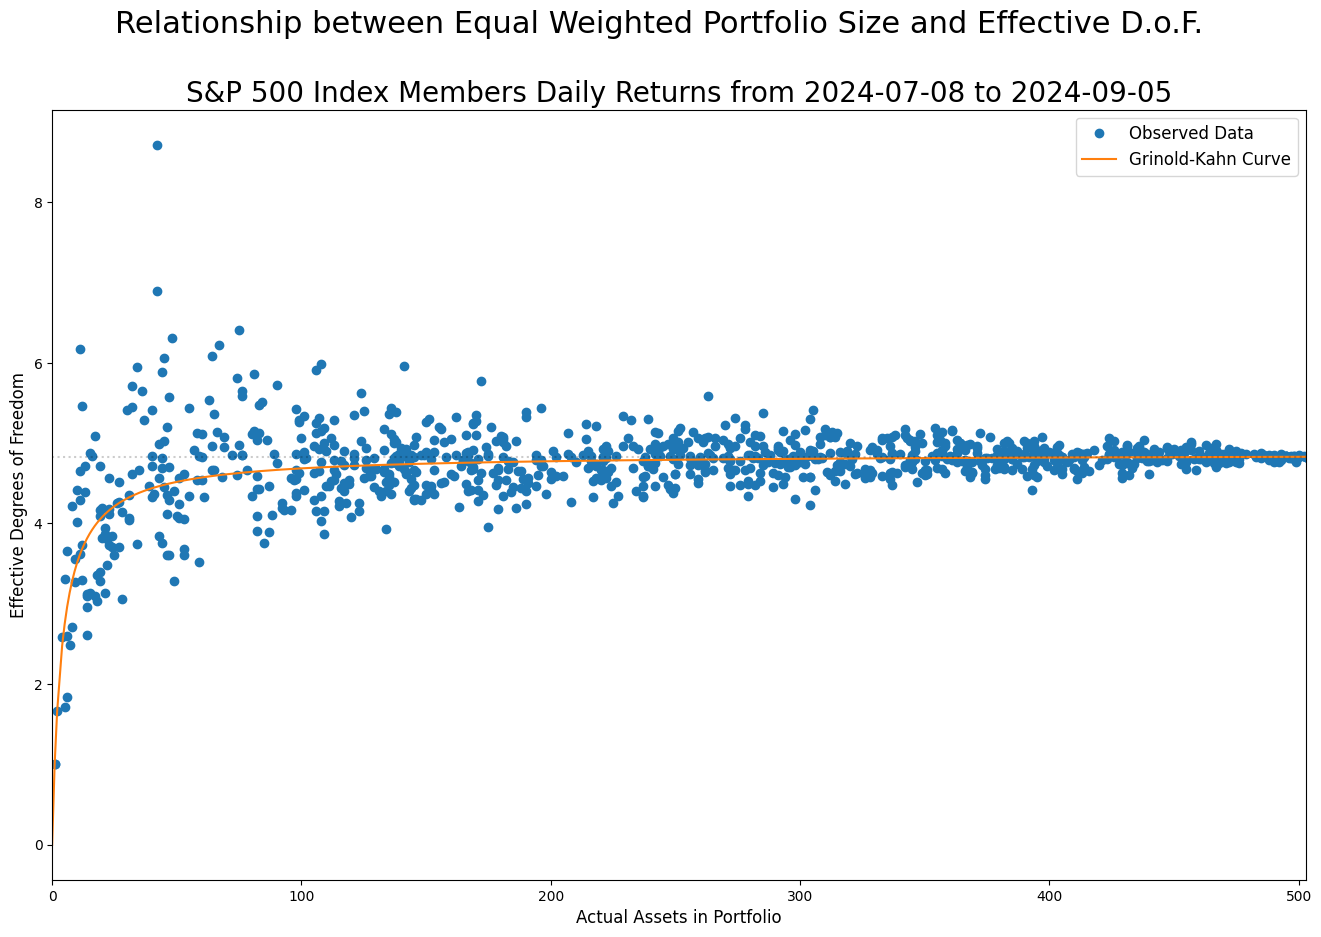

In [60]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(Nstar,rho*hundred))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members Daily Returns from %s to %s" % (indexname,first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$